# Twitter Detection Suicide

In [21]:
# Librairies to install
!pip install vaderSentiment
!pip install textblob
!pip install happytransformer
!pip install transformers

In [14]:
# Important librairy
import pandas as pd
import numpy as np
import nltk
import os
import re
import warnings
warnings.filterwarnings('ignore')

# For Modele
from nltk.tag import UnigramTagger
from nltk.corpus import treebank
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from happytransformer import HappyTextClassification
from transformers import AutoModel, AutoTokenizer
from transformers import pipeline

# Analyse des données
import seaborn as sns
from matplotlib import pyplot as plt

In [43]:
# On charge les deux dataset de test et de train
# df = pd.read_csv('./Suicide_Detection_Reddit2.csv')
#df = pd.read_csv('./Suicide_Detection_Tweeter.csv')
df = pd.read_csv(r'C:\Users\owen9\OneDrive\Documents\GitHub\TwitterFeelingAnalyse\Dataset\Suicide_Detection_Tweeter.csv')
df = df.rename(columns={
    "Tweet": "text",
    "Suicide": "class"
})
df["text"] = df["text"].astype(str)
df["class"] = df["class"].astype(str)
df.head(10)

,text,class
0,i hate myself so much i want to KILL myself ho...,Potential Suicide post
1,RT @DrugForumsBest: I woke up with a bag over ...,Potential Suicide post
2,i wanna fucking kill myself,Potential Suicide post
3,why do i destroy all my opportunities? am i go...,Potential Suicide post
4,u - understand what the fuck im doing wrong wi...,Potential Suicide post
5,"Wait I take this back, I fucking hate living i...",Potential Suicide post
6,Bitch I'm gonna kill myself what the fuck,Potential Suicide post
7,goodnight i really want to fucking kill myself,Potential Suicide post
8,I wanna kill myself like not literally but men...,Potential Suicide post
9,its crazy cause i shut myself out on two ppl i...,Potential Suicide post


In [75]:
# On affiche la dimension du dataset
print('Nombre de ligne : ' +  str(df.shape[0]))
print('Nombre de colonne : ' + str(df.shape[1]))

Nombre de ligne : 1599
Nombre de colonne : 6


# Cleaning

In [45]:
def Cleaning(Text):
    #supprimer les identifiactions avec les @
    L=[]#liste des mots à enlever
    for i in range(len(Text)):
        if Text[i]=='@':            
            s=''
            for j in Text[i:]:
                if j != ' ':
                    s+=j
                else:
                    break            
            L.append(s)
    #suppression de tous les mots
    for word in L:
        Text=Text.replace(word,'')
    
    #On garde que les caractères alphanumériques
    Text=re.sub(r'((?![a-z]|[A-Z]|\d).)',' ',Text)#((?!...).) => opposé
    
    return Text.strip() #suppression des espaces au début et à la fin

In [46]:
df['text'] = df['text'].apply(lambda x: Cleaning(x))
df.head(10)

,text,class
0,i hate myself so much i want to KILL myself ho...,Potential Suicide post
1,RT I woke up with a bag over my head after I ...,Potential Suicide post
2,i wanna fucking kill myself,Potential Suicide post
3,why do i destroy all my opportunities am i go...,Potential Suicide post
4,u understand what the fuck im doing wrong wi...,Potential Suicide post
5,Wait I take this back I fucking hate living i...,Potential Suicide post
6,Bitch I m gonna kill myself what the fuck,Potential Suicide post
7,goodnight i really want to fucking kill myself,Potential Suicide post
8,I wanna kill myself like not literally but men...,Potential Suicide post
9,its crazy cause i shut myself out on two ppl i...,Potential Suicide post


# Modeles

## Fonction Globale

In [47]:
# Instanciez le modèle et le tokeniseur
def Classificator(name):
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModel.from_pretrained(name)
    return pipeline(model=name)

In [48]:
# Keyword Analyse
train_sents = treebank.tagged_sents()[:3000]
tagger = UnigramTagger(train_sents)

# Classificateur
happy_tc = HappyTextClassification(model_type="DISTILBERT", model_name="distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)
#classifier_bert = Classificator("nlptown/bert-base-multilingual-uncased-sentiment")
#classifier_suicidal_bert = Classificator("gooohjy/suicidal-bert")

01/20/2023 10:50:48 - INFO - happytransformer.happy_transformer -   Using model: cpu


## !BUG! sur les modèles Bert

In [49]:
def AddModeleIntoDataframe(df, function_modele, list_column_name):
    df[list_column_name] = df['text'].apply(lambda x: function_modele(x))
    return df

In [50]:
def AddAllModelToDF(df):
    #cleaning du dataframe
    df["text"] = df["text"].apply(lambda x: x[:500])
    
    print("Réalisation de la fonction keyword_analyse en cours ....")
    #df = AddModeleIntoDataframe(df, sentiment_keyword, "keyword_label")
    
    print("Réalisation de la fonction sentiment_vader en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_vader, "valder_label")
    
    print("Réalisation de la fonction sentiment_texblob en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_texblob_polarity, "textbloc_polarity_label")
    df = AddModeleIntoDataframe(df, sentiment_texblob_subjectivity, "textbloc_subjectivity_label")
    
    print("Réalisation de la fonction sentiment_happy_transformer en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_happy_transformer, "happy_transformer_label")
    
    '''
    print("Réalisation de la fonction sentiment_bert en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_bert, "bert_label")
    
    print("Réalisation de la fonction sentiment_suicidal_bert en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_suicidal_bert, "suicidal_bert_label")
    '''
    
    return df

## KeyWord Analyse

In [51]:
def sentiment_keyword(text):
    texte=word_tokenize(text)
    L=set()
    tag=tagger.tag(texte)

    for t in tag:
        L.add(t[0])

    pos_score=0
    neg_score=0

    for adv in L:
        adv_senti = list(swn.senti_synsets(adv))
        if len(adv_senti)!=0:
            pos_score+=adv_senti[0].pos_score()
            neg_score+=adv_senti[0].neg_score()
    res=''
    
    if pos_score > neg_score:
        res='pos'
    elif pos_score < neg_score:
        res='neg'

    return res,pos_score,neg_score

## Valder

In [52]:
def sentiment_vader(sentence):
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"
        
    elif sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"   

    else :
        overall_sentiment = "Neutral"
  
    return overall_sentiment

## TextBlob

In [53]:
def sentiment_texblob_polarity(row):
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    return polarity

def sentiment_texblob_subjectivity(row):
    classifier = TextBlob(row)
    subjectivity = classifier.sentiment.subjectivity
    return subjectivity

## Happy Transformer

In [54]:
def sentiment_happy_transformer(row):
    result = happy_tc.classify_text(row)
    return str(result.label)

## BERT

In [27]:
def sentiment_bert(row):
    # On recupere le sentiment
    res = classifier_bert(row)

    # Ajoutez les résultats aux tableaux
    return res[0]['label'][:1]

## Suicidal BERT

In [28]:
def sentiment_suicidal_bert(row):
    # On recupere le sentiment
    res = classifier_suicidal_bert(row)

    # Ajoutez les résultats aux tableaux
    return res[0]['label']

In [55]:
df.head()

,text,class
0,i hate myself so much i want to KILL myself ho...,Potential Suicide post
1,RT I woke up with a bag over my head after I ...,Potential Suicide post
2,i wanna fucking kill myself,Potential Suicide post
3,why do i destroy all my opportunities am i go...,Potential Suicide post
4,u understand what the fuck im doing wrong wi...,Potential Suicide post


# Analyse

In [56]:
def PreparationModel(df):
    df["class"] = df["class"].replace({"Potential Suicide post ": 1, "Not Suicide post": 0})
    df["valder_label"] = df["valder_label"].replace({"Negative": 1, "Positive": 0, "Neutral": 0})
    df["happy_transformer_label"] = df["happy_transformer_label"].replace({"NEGATIVE": 1, "POSITIVE": 0})
    #df["bert_label"] = df["bert_label"].replace({"1": 1, "2": 0, "3": 0, "4": 0, "5": 0})
    #df["suicidal_bert_label"] = df["suicidal_bert_label"].replace({"LABEL_1": 1, "LABEL_0": 0})
    return df

In [57]:
df = AddAllModelToDF(df)
df = PreparationModel(df)
df.head()

Réalisation de la fonction keyword_analyse en cours ....
Réalisation de la fonction sentiment_vader en cours ....
Réalisation de la fonction sentiment_texblob en cours ....
Réalisation de la fonction sentiment_happy_transformer en cours ....


,text,class,valder_label,textbloc_polarity_label,textbloc_subjectivity_label,happy_transformer_label
0,i hate myself so much i want to KILL myself ho...,1,1,-0.300000,0.550000,1
1,RT I woke up with a bag over my head after I ...,1,0,-0.166667,0.166667,1
2,i wanna fucking kill myself,1,1,-0.600000,0.800000,1
3,why do i destroy all my opportunities am i go...,1,1,-0.228125,0.571875,1
4,u understand what the fuck im doing wrong wi...,1,1,-0.450000,0.750000,1


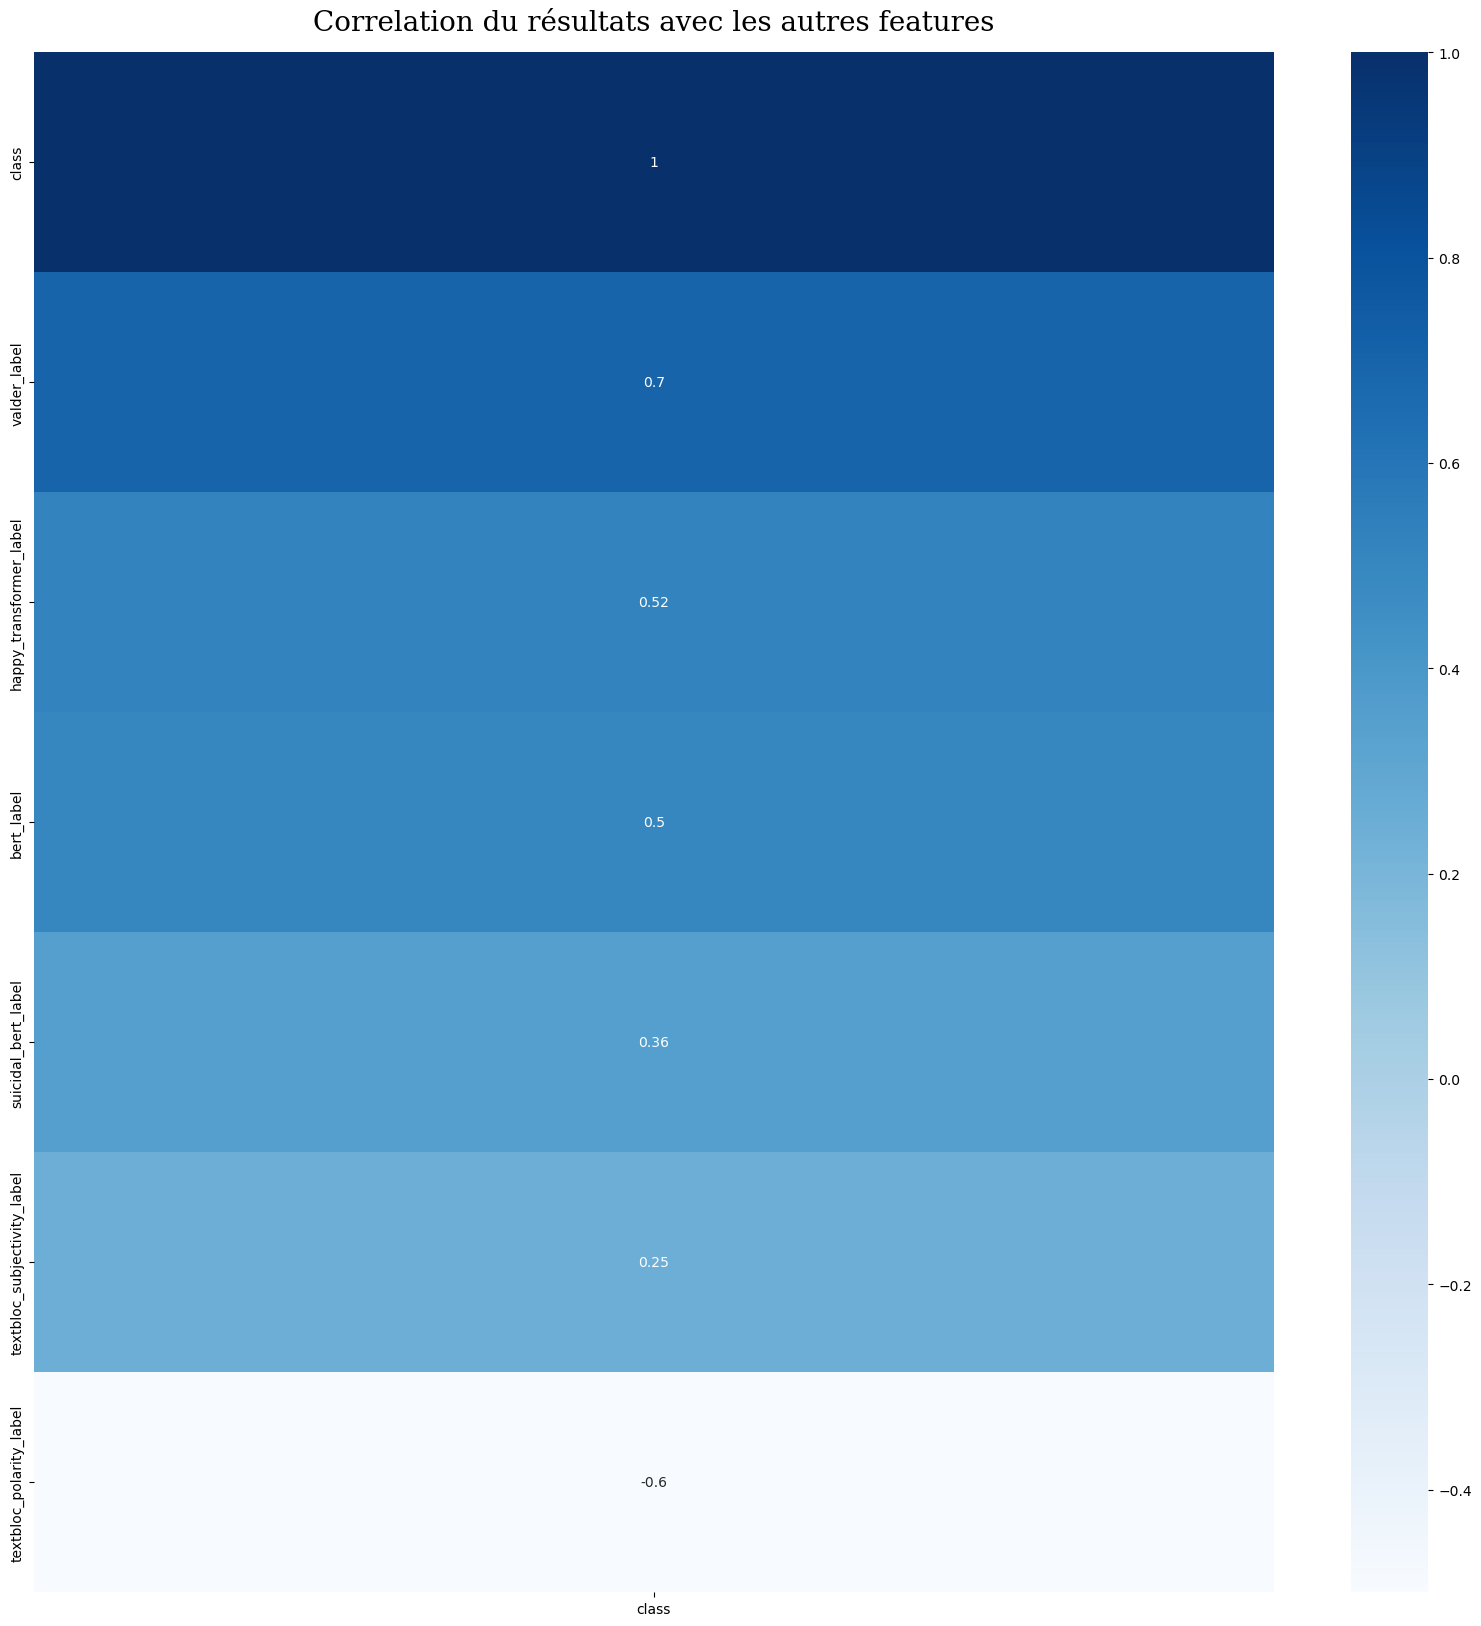

In [54]:
# Nous allons nous concentrez uniquement sur la caractéristique cible
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(df.corr()[['class']].sort_values(by='class', ascending=False), vmin=-0.5, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation du résultats avec les autres features', pad=16, fontdict={'family': 'serif','size': 20});

In [59]:
df.to_csv(r'C:\Users\owen9\OneDrive\Documents\GitHub\TwitterFeelingAnalyse\Dataset\Resultats_Owen.csv', sep=';', index=False)
#df.to_csv('./Suicide_Detection_Tweeter_Final.csv', index=False)
# df.to_csv('./Suicide_Detection_Reddit_Final.csv', index=False)

# Prediction

In [56]:
df = pd.read_csv('./Suicide_Detection_Tweeter_Final.csv')
# df = pd.read_csv('./Suicide_Detection_Reddit_Final.csv')

In [57]:
def TauxBonneReponse(df):
    # Sélection des lignes où la colonne "class" contient la valeur 1
    selected_true_positive = df.loc[df['class'] == 1]
    return [selected_true_positive.shape[0], df.shape[0], round(selected_true_positive.shape[0] / df.shape[0], 2)]

In [58]:
# Genere un dataframe ou stock le meilleur modele pour chaque méthode
ResultDf = pd.DataFrame()
def StockResultDf(name, df):
    global ResultDf
    tab = TauxBonneReponse(df)
    listValue = {'Methode Name': name, 'Nombre de bonne reponse': tab[0], 'Nombre de réponse totale': tab[1] , 'Taux de bonne réponse (%)': tab[2]}
    ResultDf = ResultDf.append(listValue,ignore_index=True)

In [59]:
def SelectionTweetSuicidaire(df):
    #Methode Naif
    StockResultDf("Naif", df)
    
    #Methode 1
    # On ne garde que suicidal bert
    df1 = df[df['suicidal_bert_label'] == 1]
    StockResultDf("Model 1", df1)
    
    #Methode 2
    # Sélection des lignes où au moins 3 des colonnes ont la valeur 1
    df2 = df[(df[['valder_label', 'happy_transformer_label', 'bert_label', 'suicidal_bert_label']].sum(axis=1) >= 3)]
    StockResultDf("Model 2", df2)
    
#On execute puis on affiche le resultat
SelectionTweetSuicidaire(df.copy())
ResultDf

,Methode Name,Nombre de bonne reponse,Nombre de réponse totale,Taux de bonne réponse (%)
0,Naif,560,1599,0.35
1,Model 1,188,254,0.74
2,Model 2,397,453,0.88


# Matrice de confusion

In [60]:
df.head()

,text,class,valder_label,textbloc_polarity_label,textbloc_subjectivity_label,happy_transformer_label
0,i hate myself so much i want to KILL myself ho...,1,1,-0.300000,0.550000,1
1,RT I woke up with a bag over my head after I ...,1,0,-0.166667,0.166667,1
2,i wanna fucking kill myself,1,1,-0.600000,0.800000,1
3,why do i destroy all my opportunities am i go...,1,1,-0.228125,0.571875,1
4,u understand what the fuck im doing wrong wi...,1,1,-0.450000,0.750000,1


In [87]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true=df['class'], y_pred=df['valder_label'])
print(matrix)

[[951  88]
 [114 446]]


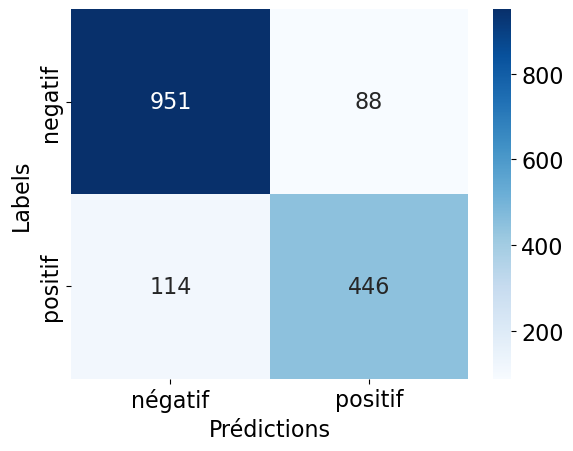

In [108]:
df_matrix = pd.DataFrame(matrix, ['negatif','positif'], ['négatif','positif'])
cmap=plt.cm.Blues
sn.heatmap(df_matrix, cmap=cmap, annot=True, fmt='d')
plt.xlabel('Prédictions')
plt.ylabel('Labels')
plt.show()

In [128]:
tot=np.sum(matrix)
matrix2 = matrix/tot
print(matrix2)

[[0.59474672 0.0550344 ]
 [0.07129456 0.27892433]]


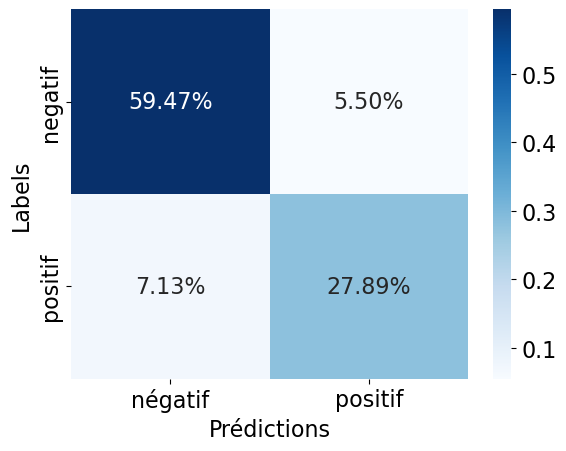

In [129]:
df_matrix = pd.DataFrame(matrix2, ['negatif','positif'], ['négatif','positif'])
cmap=plt.cm.Blues
sn.heatmap(df_matrix, cmap=cmap, annot=True, fmt='.2%')
plt.xlabel('Prédictions')
plt.ylabel('Labels')
plt.show()